<a href="https://colab.research.google.com/github/RITIK-12/tCrop/blob/main/Paddy_Thermal_Image_Classification_Custom_CNN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wandb
!wandb login

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 180 kB 45.8 MB/s 
     |████████████████████████████████| 140 kB 45.6 MB/s 
     |████████████████████████████████| 97 kB 6.5 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=ab15e9d682a1fe8fc4ef3242ec513f793fe82318caba400d6846cb228cca9165
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=882af18fc8051855c9a125e193cd64cec4aeedc47c31929fbb0bc9bcad63dd9a
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or p

In [ ]:
import wandb
wandb.init(project="diseaseClassification", entity="ritik")

wandb: Currently logged in as: ritik (use `wandb login --relogin` to force relogin)


In [ ]:
from wandb.keras import WandbCallback

In [ ]:
wandb.config = {
  "learning_rate": 0.001,
  "epochs": 30,
  "batch_size": 16
}

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import pathlib
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import numpy
from sklearn.metrics import confusion_matrix
import itertools

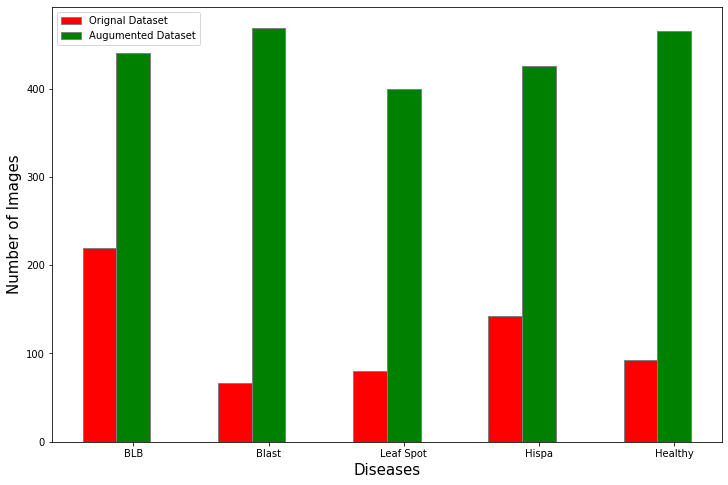

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# set height of bar
pre = [220, 67, 80, 142, 93]
rec = [440, 469, 400, 426, 465]
#f1 = [0.48, 0.37, 0.52, 0.30]

# Set position of bar on X axis
br1 = np.arange(len(pre))
br2 = [x + barWidth for x in br1]
# br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, pre, color ='r', width = barWidth,
		edgecolor ='grey', label ='Orignal Dataset')
plt.bar(br2, rec, color ='g', width = barWidth,
		edgecolor ='grey', label ='Augumented Dataset')
# plt.bar(br3, f1, color ='b', width = barWidth,
# 		edgecolor ='grey', label ='F1-Score')

# Adding Xticks
plt.xlabel('Diseases',  fontsize = 15)
plt.ylabel('Number of Images',  fontsize = 15)
plt.xticks([r + barWidth for r in range(len(pre))],
		['BLB', 'Blast', 'Leaf Spot', 'Hispa', 'Healthy'])

plt.legend()
plt.savefig('/content/data_augmentations.png')
plt.show()


In [ ]:
data_dir = '/content/drive/MyDrive/PlantStressDetection/ThermalPaddyImages/Dataset/'
data_dir = pathlib.Path(data_dir)
train_dir = '/content/drive/MyDrive/PlantStressDetection/ThermalPaddyImages/Dataset/train/'
train_dir = pathlib.Path(train_dir)
test_dir = '/content/drive/MyDrive/PlantStressDetection/ThermalPaddyImages/Dataset/test/'
test_dir = pathlib.Path(test_dir)
valid_dir = '/content/drive/MyDrive/PlantStressDetection/ThermalPaddyImages/Dataset/val/'
valid_dir = pathlib.Path(valid_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

0


In [ ]:
batch_size = 16
img_height = 224
img_width = 224

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical'
  )

Found 1539 files belonging to 5 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  valid_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 439 files belonging to 5 classes.


In [ ]:
test_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode = "categorical",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=1, shuffle = False)

Found 222 files belonging to 5 classes.


In [ ]:
class_names = test_ds.class_names
print(class_names)

['BLB', 'Blast', 'healthy', 'hispa', 'leaf_spot']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 224, 224, 3)
(16, 5)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) 

In [ ]:
filepath = "/content/drive/MyDrive/PlantDiseaseThermal/WandBmodels/Custom1.h5"

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_save = tf.keras.callbacks.ModelCheckpoint(filepath, monitor="val_accuracy", verbose=0, save_best_only=True, save_weights_only=False, mode="max", save_freq="epoch")
 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=4,
                                   verbose=1,
                                   min_delta=1e-3,min_lr = 5*1e-12,
                                   )

callbacks = [model_save,  reduce_lr, WandbCallback()]

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (10, 10), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, (7, 7), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(96, (5, 5), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (5, 5), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.GlobalMaxPooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 215, 215, 32)      9632      
                                                                 
 batch_normalization_5 (Batc  (None, 215, 215, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 107, 107, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 101, 101, 64)      100416    
                                                                 
 batch_normalization_6 (Batc  (None, 101, 101, 64)     256       
 hNormalization)                                                 
                                                      

In [ ]:
model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics='accuracy')

In [ ]:
history =  model.fit(train_ds, validation_data=val_ds, steps_per_epoch=np.ceil(float(1539)/float(batch_size)), epochs = 30,callbacks= callbacks, validation_steps=np.ceil(float(439)/float(batch_size)), use_multiprocessing= True)

Epoch 1/30
97/97 [==============================] - 222s 2s/step - loss: 1.9785 - accuracy: 0.3827 - val_loss: 6.5169 - val_accuracy: 0.2506 - lr: 0.0010
Epoch 2/30
97/97 [==============================] - 17s 174ms/step - loss: 1.2252 - accuracy: 0.5094 - val_loss: 1.9802 - val_accuracy: 0.3759 - lr: 0.0010
Epoch 3/30
97/97 [==============================] - 17s 175ms/step - loss: 0.9527 - accuracy: 0.6225 - val_loss: 0.9852 - val_accuracy: 0.6082 - lr: 0.0010
Epoch 4/30
97/97 [==============================] - 17s 174ms/step - loss: 0.8112 - accuracy: 0.6810 - val_loss: 0.7698 - val_accuracy: 0.6993 - lr: 0.0010
Epoch 5/30
97/97 [==============================] - 17s 174ms/step - loss: 0.7200 - accuracy: 0.7212 - val_loss: 0.7792 - val_accuracy: 0.7175 - lr: 0.0010
Epoch 6/30
97/97 [==============================] - 16s 168ms/step - loss: 0.6647 - accuracy: 0.7407 - val_loss: 0.8855 - val_accuracy: 0.7153 - lr: 0.0010
Epoch 7/30
97/97 [==============================] - 16s 168ms/step

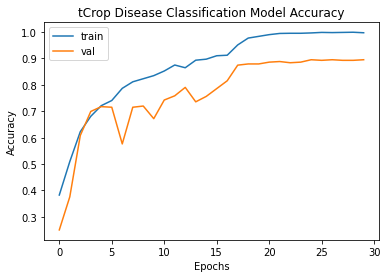

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('tCrop Disease Classification Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('/content/drive/MyDrive/PlantDiseaseThermal/figures/custom_1_acc.png', bbox_inches='tight')
plt.show()

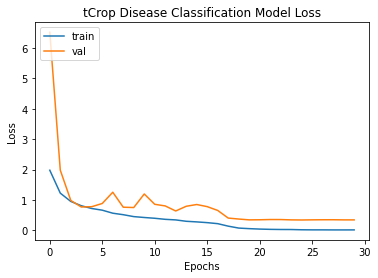

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('tCrop Disease Classification Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('/content/drive/MyDrive/PlantDiseaseThermal/figures/custom_1_loss.png', bbox_inches='tight')
plt.show()

In [ ]:
#Prediction Function
array = model.predict(test_ds, batch_size=1, verbose=1)
y_pred = np.argmax(array, axis=1)

222/222 [==============================] - 29s 128ms/step


In [ ]:
y_true = y = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
rounded_labels=np.argmax(y_true, axis=1)
rounded_labels[1]

0

In [ ]:
conf_mat = confusion_matrix(rounded_labels, y_pred)

In [ ]:
conf_mat

array([[42,  0,  1,  1,  0],
       [ 0, 41,  1,  3,  3],
       [ 0,  0, 46,  1,  0],
       [ 2,  0,  0, 41,  0],
       [ 1,  0,  1,  1, 37]])

In [ ]:
classes = class_names

In [ ]:
from sklearn import metrics
report = metrics.classification_report(rounded_labels, y_pred, target_names=classes)
print(report) 

              precision    recall  f1-score   support

         BLB       0.93      0.95      0.94        44
       Blast       1.00      0.85      0.92        48
     healthy       0.94      0.98      0.96        47
       hispa       0.87      0.95      0.91        43
   leaf_spot       0.93      0.93      0.93        40

    accuracy                           0.93       222
   macro avg       0.93      0.93      0.93       222
weighted avg       0.94      0.93      0.93       222



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    plt.savefig('/content/drive/MyDrive/PlantDiseaseThermal/figures/ConfusionMetrics/{}1.jpg'.format(title))
    plt.show()

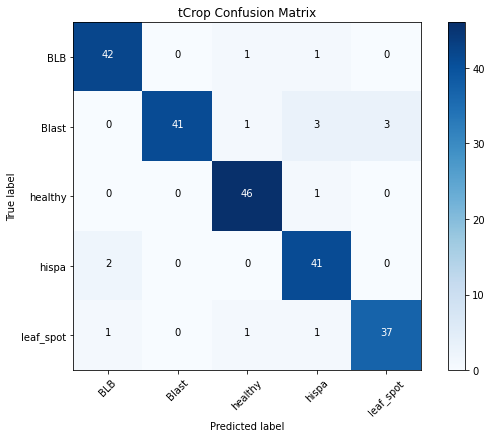

In [ ]:
plot_confusion_matrix(conf_mat,target_names=classes,title='tCrop Confusion Matrix',normalize=False)

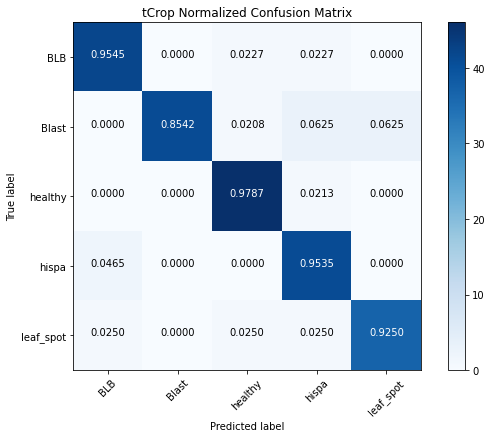

In [ ]:
plot_confusion_matrix(conf_mat,target_names=classes,title='tCrop Normalized Confusion Matrix',normalize=True)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/PlantDiseaseThermal/WandBmodels/Custom1.h5')

In [ ]:
import tensorflow as tf

# To Convert the Keras model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Using float 16 quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

# Converting the model 
tflite_fp16_model = converter.convert()

# Saving the model.
with open('/content/drive/MyDrive/PlantDiseaseThermal/WandBmodels/model.tflite', 'wb') as f:
  f.write(tflite_fp16_model)

INFO:tensorflow:Assets written to: /tmp/tmppu_mirqu/assets


In [ ]:
#Importing Libraries
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [ ]:
#Defining Image Data Generator
gen =ImageDataGenerator()

In [ ]:
#Loading Test Set
test_datagen_new = gen.flow_from_directory(
    '/content/drive/MyDrive/PlantStressDetection/ThermalPaddyImages/Dataset/test/',
    target_size=(224, 224),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=222,
    shuffle=False,
    interpolation="nearest"
)

Found 222 images belonging to 5 classes.


In [ ]:
#Dataset Labels 
dataset_labels = sorted(test_datagen_new.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Blb' 'Blast' 'Healthy' 'Hispa' 'Leaf_Spot']


In [ ]:
# Get images and labels batch from validation dataset generator
test_image_batch, test_label_batch = next(iter(test_datagen_new))
test_image_batch = test_image_batch.astype('float32')
#test_image_batch = (x.astype(np.uint8) for x in test_image_batch)
#test_image_batch =  tf.cast(test_image_batch, tf.float32)/255.0
true_label_ids = np.argmax(test_label_batch,  axis=0)
print("test batch shape:", test_image_batch.shape)

test batch shape: (222, 224, 224, 3)


In [ ]:
#True Labels for images
true_label_ids = test_label_batch.squeeze().argmax(axis = 1)

In [ ]:
true_label_ids

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4])

In [ ]:
tflite_interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/PlantDiseaseThermal/WandBmodels/model.tflite")

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
shape: [1 5]
type: <class 'numpy.float32'>


In [ ]:
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (222, 224, 224, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (222, 5))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_details[0]['shape'])
print("\n== Output details ==")
print("shape:", output_details[0]['shape'])

== Input details ==
shape: [222 224 224   3]

== Output details ==
shape: [222   5]


In [ ]:
# Set batch of images into input tensor
tflite_interpreter.set_tensor(input_details[0]['index'], test_image_batch)# test_datagen_new )#
# Run inference
tflite_interpreter.invoke()
# Get prediction results
tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)

Prediction results shape: (222, 5)


In [ ]:
tflite_model_predictions = tflite_model_predictions.squeeze().argmax(axis = 1)

In [ ]:
classes = dataset_labels
conf_mat1 = confusion_matrix(true_label_ids, tflite_model_predictions)

In [ ]:
#Classification Report
report1 = metrics.classification_report(true_label_ids, tflite_model_predictions, target_names=classes)
print(report1) 

              precision    recall  f1-score   support

         Blb       0.93      0.95      0.94        44
       Blast       1.00      0.85      0.92        48
     Healthy       0.96      0.98      0.97        47
       Hispa       0.87      0.95      0.91        43
   Leaf_Spot       0.93      0.95      0.94        40

    accuracy                           0.94       222
   macro avg       0.94      0.94      0.94       222
weighted avg       0.94      0.94      0.94       222



In [ ]:
conf_mat1

array([[42,  0,  1,  1,  0],
       [ 0, 41,  1,  3,  3],
       [ 0,  0, 46,  1,  0],
       [ 2,  0,  0, 41,  0],
       [ 1,  0,  0,  1, 38]])

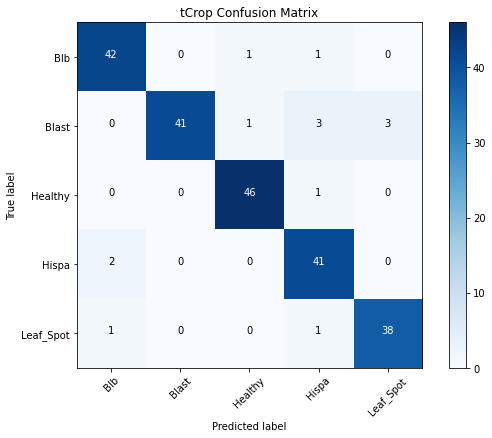

In [ ]:
plot_confusion_matrix(conf_mat1,target_names=classes,title='tCrop Confusion Matrix',normalize=False)